In [1]:
# import libraries
import os
from google.colab import userdata
from google.colab import output
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [2]:
# Import github token with google secrets thingy and clone git repository
GITHUB_TOKEN = userdata.get('github')
os.environ['GITHUB_TOKEN'] = GITHUB_TOKEN
!git clone https://{GITHUB_TOKEN}@github.com/Kussil/Financial_Sentiment_LLM.git

Cloning into 'Financial_Sentiment_LLM'...
remote: Enumerating objects: 2345, done.
remote: Counting objects: 100% (750/750), done.
remote: Compressing objects: 100% (351/351), done.
remote: Total 2345 (delta 476), reused 648 (delta 386), pack-reused 1595
Receiving objects: 100% (2345/2345), 475.37 MiB | 14.26 MiB/s, done.
Resolving deltas: 100% (1559/1559), done.
Updating files: 100% (1177/1177), done.


In [3]:
# Load prepped data
gemini_sentiment = pd.read_csv('/content/Financial_Sentiment_LLM/04_Stock_Modeling/02_Prompt2_Gemini_Prepped_Stock_Data.csv')
print(gemini_sentiment.shape)
display(gemini_sentiment.head())
print(gemini_sentiment.isna().sum())

(9474, 12)


,Source,Unique_ID,Ticker,Date,URL,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price,Returns
0,ProQuest,PQ-2463687415,BP,2019-01-09,https://www.proquest.com/newspapers/markets-co...,Positive,Neutral,Positive,Neutral,Neutral,Neutral,0.008244
1,ProQuest,PQ-2311280728,BP,2019-02-11,https://www.proquest.com/newspapers/arabia-sau...,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,-0.006589
2,Investment Research,IR-4891,BP,2019-02-20,NaN,Positive,Positive,Neutral,Neutral,Neutral,Positive,0.002360
3,ProQuest,PQ-2300507429,BP,2019-03-10,https://www.proquest.com/newspapers/bp-ceo-ste...,Positive,Neutral,Neutral,Negative,Neutral,Neutral,0.001894
4,ProQuest,PQ-2311444292,BP,2019-03-11,https://www.proquest.com/newspapers/aramco-arr...,Positive,Neutral,Neutral,Neutral,Negative,Neutral,0.001894


Source             0
Unique_ID          0
Ticker             0
Date               0
URL             4887
Finance            0
Production         0
Reserves/M&A       0
Regulatory         0
Green Energy       0
OG Price           0
Returns            0
dtype: int64


In [4]:
# Drop extra columns
gemini_sentiment = gemini_sentiment.drop(['Unique_ID','URL'], axis=1)

# Convert the 'Date' column to datetime
gemini_sentiment['Date'] = pd.to_datetime(gemini_sentiment['Date'])
display(gemini_sentiment.head())

,Source,Ticker,Date,Finance,Production,Reserves/M&A,Regulatory,Green Energy,OG Price,Returns
0,ProQuest,BP,2019-01-09,Positive,Neutral,Positive,Neutral,Neutral,Neutral,0.008244
1,ProQuest,BP,2019-02-11,Neutral,Neutral,Neutral,Neutral,Neutral,Neutral,-0.006589
2,Investment Research,BP,2019-02-20,Positive,Positive,Neutral,Neutral,Neutral,Positive,0.002360
3,ProQuest,BP,2019-03-10,Positive,Neutral,Neutral,Negative,Neutral,Neutral,0.001894
4,ProQuest,BP,2019-03-11,Positive,Neutral,Neutral,Neutral,Negative,Neutral,0.001894


In [5]:
# One hot encode categorical variables
gemini_sentiment_encoded = pd.get_dummies(gemini_sentiment, columns=['Ticker',
                                                                     'Source',
                                                                     'Finance',
                                                                     'Production',
                                                                     'Reserves/M&A',
                                                                     'Regulatory',
                                                                     'Green Energy',
                                                                     'OG Price'], drop_first=True)
display(gemini_sentiment_encoded.head())

,Date,Returns,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_EQNR,Ticker_HES,Ticker_MPC,Ticker_MRO,...,Production_Neutral,Production_Positive,Reserves/M&A_Neutral,Reserves/M&A_Positive,Regulatory_Neutral,Regulatory_Positive,Green Energy_Neutral,Green Energy_Positive,OG Price_Neutral,OG Price_Positive
0,2019-01-09,0.008244,False,False,False,False,False,False,False,False,...,True,False,False,True,True,False,True,False,True,False
1,2019-02-11,-0.006589,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
2,2019-02-20,0.002360,False,False,False,False,False,False,False,False,...,False,True,True,False,True,False,True,False,False,True
3,2019-03-10,0.001894,False,False,False,False,False,False,False,False,...,True,False,True,False,False,False,True,False,True,False
4,2019-03-11,0.001894,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,False,False,True,False


In [6]:
# Split into test and train
split_date = pd.to_datetime('2024-01-01')

# Split the DataFrame
train_df = gemini_sentiment_encoded[(gemini_sentiment_encoded['Date'] < split_date)]
test_df = gemini_sentiment_encoded[gemini_sentiment_encoded['Date'] >= split_date]

display(train_df.tail())
display(test_df.head())

,Date,Returns,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_EQNR,Ticker_HES,Ticker_MPC,Ticker_MRO,...,Production_Neutral,Production_Positive,Reserves/M&A_Neutral,Reserves/M&A_Positive,Regulatory_Neutral,Regulatory_Positive,Green Energy_Neutral,Green Energy_Positive,OG Price_Neutral,OG Price_Positive
9408,2023-12-13,0.008873,False,False,False,False,False,False,False,False,...,True,False,False,False,False,True,False,True,True,False
9409,2023-12-16,-0.016701,False,False,False,False,False,False,False,False,...,False,True,False,True,True,False,False,True,False,True
9410,2023-12-20,-0.016701,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
9411,2023-12-23,0.008402,False,False,False,False,False,False,False,False,...,False,True,False,True,True,False,False,True,False,True
9412,2023-12-30,0.008402,False,False,False,False,False,False,False,False,...,True,False,False,True,True,False,False,True,True,False


,Date,Returns,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_EQNR,Ticker_HES,Ticker_MPC,Ticker_MRO,...,Production_Neutral,Production_Positive,Reserves/M&A_Neutral,Reserves/M&A_Positive,Regulatory_Neutral,Regulatory_Positive,Green Energy_Neutral,Green Energy_Positive,OG Price_Neutral,OG Price_Positive
742,2024-01-02,0.002825,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
743,2024-01-03,0.014085,False,False,False,False,False,False,False,False,...,True,False,False,True,False,True,False,True,True,False
744,2024-01-13,-0.016638,False,False,False,False,False,False,False,False,...,False,False,False,True,True,False,False,True,True,False
745,2024-01-16,-0.016638,False,False,False,False,False,False,False,False,...,False,True,True,False,True,False,True,False,True,False
746,2024-01-16,-0.016638,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False


In [7]:
# Define X and y
X_train = train_df.drop(columns=['Date','Returns'])
X_test = test_df.drop(columns=['Date','Returns'])

y_train = train_df['Returns'].apply(lambda x: 1 if x > 0.0 else 0)
y_test = test_df['Returns'].apply(lambda x: 1 if x > 0.0 else 0)

print(len(X_train), len(y_train), len(X_test), len(y_test))
display(X_train.head())
display(y_train.head())

8981 8981 493 493


,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_EQNR,Ticker_HES,Ticker_MPC,Ticker_MRO,Ticker_OXY,Ticker_PSX,...,Production_Neutral,Production_Positive,Reserves/M&A_Neutral,Reserves/M&A_Positive,Regulatory_Neutral,Regulatory_Positive,Green Energy_Neutral,Green Energy_Positive,OG Price_Neutral,OG Price_Positive
0,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,True,False,True,False,True,False
1,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,True,False,True,False
2,False,False,False,False,False,False,False,False,False,False,...,False,True,True,False,True,False,True,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,False,False,True,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,False,False,True,False


0    1
1    0
2    1
3    1
4    1
Name: Returns, dtype: int64

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.38      0.43       248
           1       0.49      0.61      0.55       245

    accuracy                           0.49       493
   macro avg       0.49      0.49      0.49       493
weighted avg       0.49      0.49      0.49       493



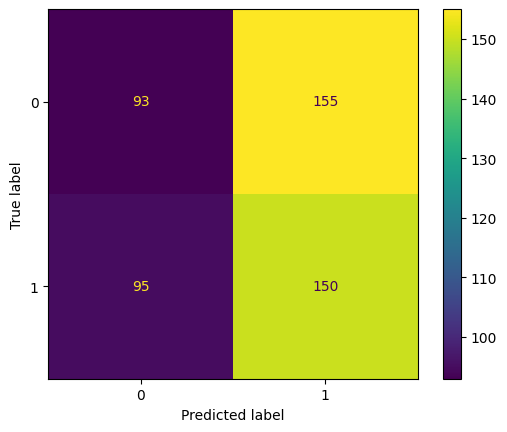

In [8]:
# Baseline XGBoost
XGB = XGBClassifier(random_state=42)
XGB.fit(X_train, y_train)
y_pred = XGB.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(XGB, X_test, y_test)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
{'eta': 0.01, 'max_depth': 9, 'n_estimators': 25}
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.09      0.15       248
           1       0.49      0.89      0.63       245

    accuracy                           0.48       493
   macro avg       0.46      0.49      0.39       493
weighted avg       0.46      0.48      0.39       493



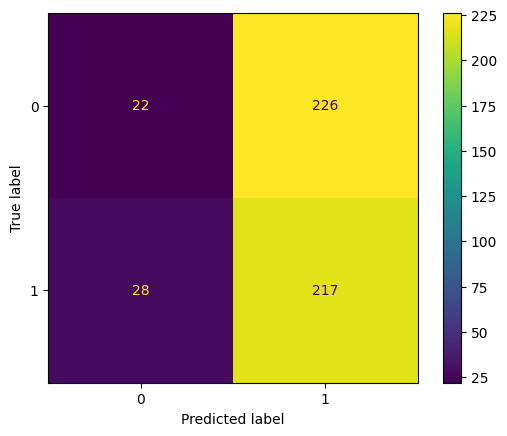

In [9]:
# Tuned XGBoost

# Define the parameter grid
param_grid = {
    'n_estimators': [25, 50, 75, 100],
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [1, 3, 6, 9]
}

# Create an XGBoost classifier
XGB = XGBClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=XGB, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

# Make predictions on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test)

In [10]:
# Since dates can have multiple articles and therefore multiple predictions, we can
# pick the result with the highest probability.  This might be important for the next steps,
# but currently this is just a placeholder

# Predict probabilities and classes
y_pred_proba = best_model.predict_proba(X_test)
y_pred = best_model.predict(X_test)

# Create a DataFrame with the results
results_df = pd.DataFrame(X_test, columns=X_test.columns)
results_df['Actual'] = y_test
results_df['Predicted_Class'] = y_pred
results_df['Predicted_Probability_Class_0'] = y_pred_proba[:, 0]
results_df['Predicted_Probability_Class_1'] = y_pred_proba[:, 1]
display(results_df.head())

,Ticker_COP,Ticker_CVX,Ticker_DVN,Ticker_EOG,Ticker_EQNR,Ticker_HES,Ticker_MPC,Ticker_MRO,Ticker_OXY,Ticker_PSX,...,Regulatory_Neutral,Regulatory_Positive,Green Energy_Neutral,Green Energy_Positive,OG Price_Neutral,OG Price_Positive,Actual,Predicted_Class,Predicted_Probability_Class_0,Predicted_Probability_Class_1
742,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,1,1,0.479308,0.520692
743,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,True,False,1,1,0.490691,0.509309
744,False,False,False,False,False,False,False,False,False,False,...,True,False,False,True,True,False,0,1,0.485994,0.514006
745,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,0,1,0.488348,0.511652
746,False,False,False,False,False,False,False,False,False,False,...,True,False,True,False,True,False,0,1,0.488348,0.511652
